# Accidents Analysis in Barcelona


### Imports

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from numpy.random import RandomState



## EDA

### Data cleaning

In [118]:
csv_dir=r'C:\Users\HP\Desktop\Projects\Reto Hackathon barcelona activa\2023_accidents_causa_conductor_gu_bcn_.csv'
data=pd.read_csv(csv_dir)

In [119]:
data.head(5)

,Numero_expedient,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Codi_carrer,Nom_carrer,Num_postal,Descripcio_dia_setmana,NK_Any,Mes_any,Nom_mes,Dia_mes,Hora_dia,Descripcio_torn,Descripcio_causa_mediata,Coordenada_UTM_X_ED50,Coordenada_UTM_Y_ED50,Longitud_WGS84,Latitud_WGS84
0,2023S000699,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Dissabte,2023,2,Febrer,4,16,Tarda,Manca d'atenció a la conducció,430443.36,4585232.00,2.166596,41.413783
1,2023S005197,-1,Desconegut,-1,Desconegut,-1,Estatut de Catalunya ...,11,Divendres,2023,9,Setembre,1,13,Matí,No respectar distàncies,429493.73,4587108.15,2.155015,41.430598
2,2023S007430,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Divendres,2023,12,Desembre,15,11,Matí,No respectar distàncies,430443.36,4585232.00,2.166596,41.413783
3,2023S000961,-1,Desconegut,-1,Desconegut,-1,Amílcar ...,120,Dissabte,2023,1,Gener,28,14,Tarda,No respectat pas de vianants,430955.45,4586335.10,2.172596,41.423762
4,2023S006486,-1,Desconegut,-1,Desconegut,-1,Augusta / Hort de la Vila ...,NaN,Dijous,2023,11,Novembre,2,14,Tarda,Desobeir semàfor,426883.33,4583690.92,2.124189,41.399587


Num_postal has an error in the colum name

In [120]:
data.columns=data.columns.str.strip().str.lower() #Num_postal with typo in the column name

This will clean any typos in the categorical columns

In [121]:
def get_categorical_columns(df):
    return df.select_dtypes(include=['object']).columns.tolist()
cat_cols=get_categorical_columns(data)

for col in cat_cols:
    if data[col].isnull().any():
        data[col] = data[col].fillna('')
    data[col] = data[col].str.strip()
    data[col] = data[col].str.replace(' ', '_')
    data[col]=data[col].str.lower()
cat_cols

['numero_expedient',
 'nom_districte',
 'nom_barri',
 'nom_carrer',
 'num_postal',
 'descripcio_dia_setmana',
 'nom_mes',
 'descripcio_torn',
 'descripcio_causa_mediata']

#### Duplicates

In [122]:
print(f'Duplicated rows:{data.duplicated().sum()}')
print (f'first row duplicates: {data['numero_expedient'].duplicated().sum()}')

Duplicated rows:0
first row duplicates: 1176


In [123]:
# some accidents have the same 'Numero_expedient' but different 'Descripcio_causa_mediata',
#  so I'm keeping the first one and dropping the rest

duplicates = data.duplicated(subset=['numero_expedient'], keep=False)

# Filter rows that are not duplicates or that do not have 'Altres' in 'Descripcio_causa_mediata'

data = data.loc[~((data['descripcio_causa_mediata'] == 'altres') & duplicates)]


### Typos

In [124]:
# nom_districte has 104 rows that are 'desconegut'(unknown), I will drop them

data=data[data['nom_districte']!='desconegut']

count_desconegut = (data['nom_districte'] == 'desconegut').sum()
print(count_desconegut)

0


In [125]:
data.sample(10)

,numero_expedient,codi_districte,nom_districte,codi_barri,nom_barri,codi_carrer,nom_carrer,num_postal,descripcio_dia_setmana,nk_any,mes_any,nom_mes,dia_mes,hora_dia,descripcio_torn,descripcio_causa_mediata,coordenada_utm_x_ed50,coordenada_utm_y_ed50,longitud_wgs84,latitud_wgs84
8314,2023s005805,2,eixample,5,el_fort_pienc,9209,alí_bei,0051_0053,dilluns,2023,10,octubre,2,15,tarda,gir_indegut_o_sense_precaució,431558.69,4582921.93,2.180201,41.393073
5311,2023s007640,6,gràcia,28,vallcarca_i_els_penitents,158107,vallcarca,0066_0066,dissabte,2023,12,desembre,23,16,tarda,altres,428821.14,4584854.28,2.147231,41.410239
6632,2023s000578,8,nou_barris,45,porta,700021,andreu_nin,0029x0029x,dilluns,2023,1,gener,30,15,tarda,gir_indegut_o_sense_precaució,431723.34,4587514.12,2.181652,41.434447
1879,2023s006315,5,sarrià-sant_gervasi,24,les_tres_torres,54906,calatrava,0090_0090,dimecres,2023,10,octubre,25,19,tarda,desobeir_altres_senyals,427169.82,4583981.48,2.127581,41.402230
8529,2023s002782,5,sarrià-sant_gervasi,26,sant_gervasi_-_galvany,148806,granada_del_penedès,0001_0001,dimecres,2023,5,maig,10,11,matí,manca_d'atenció_a_la_conducció,429378.61,4583452.96,2.154064,41.397667
8125,2023s005427,2,eixample,8,l'antiga_esquerra_de_l'eixample,32700,balmes,0063_0063,dijous,2023,9,setembre,14,0,nit,manca_d'atenció_a_la_conducció,429993.24,4582628.89,2.161511,41.390299
1217,2023s001695,1,ciutat_vella,2,el_barri_gòtic,82901,colom,0018_0018,dijous,2023,3,març,23,21,tarda,manca_d'atenció_a_la_conducció,431498.59,4581313.83,2.179664,41.378584
8161,2023s004500,2,eixample,8,l'antiga_esquerra_de_l'eixample,169409,corts_catalanes,0585_0585,dimarts,2023,7,juliol,25,15,tarda,desobeir_altres_senyals,430121.36,4582099.83,2.163105,41.385545
7566,2023s006955,7,horta-guinardó,40,montbau,701267,dalt_(besòs),001160000,dijous,2023,11,novembre,23,13,matí,canvi_de_carril_sense_precaució,428744.95,4587406.84,2.146019,41.433222
8015,2023s007194,2,eixample,10,sant_antoni,323203,sepúlveda,0015_0015,diumenge,2023,12,desembre,3,11,matí,no_determinada,429269.66,4581057.55,2.153041,41.376083


In [126]:
for col in data.columns:
    print(f'{col}: {data[col].nunique()}')

numero_expedient: 7631
codi_districte: 10
nom_districte: 10
codi_barri: 73
nom_barri: 73
codi_carrer: 1073
nom_carrer: 1040
num_postal: 1908
descripcio_dia_setmana: 7
nk_any: 1
mes_any: 12
nom_mes: 12
dia_mes: 31
hora_dia: 24
descripcio_torn: 3
descripcio_causa_mediata: 16
coordenada_utm_x_ed50: 4756
coordenada_utm_y_ed50: 4752
longitud_wgs84: 4770
latitud_wgs84: 4770


codi_carrer cleaning    

In [127]:
#codi_carrer unique values: 1073. nom_carrer: unique values: 1073
data.drop('codi_carrer', axis=1, inplace=True)


## Visualizacion de datos

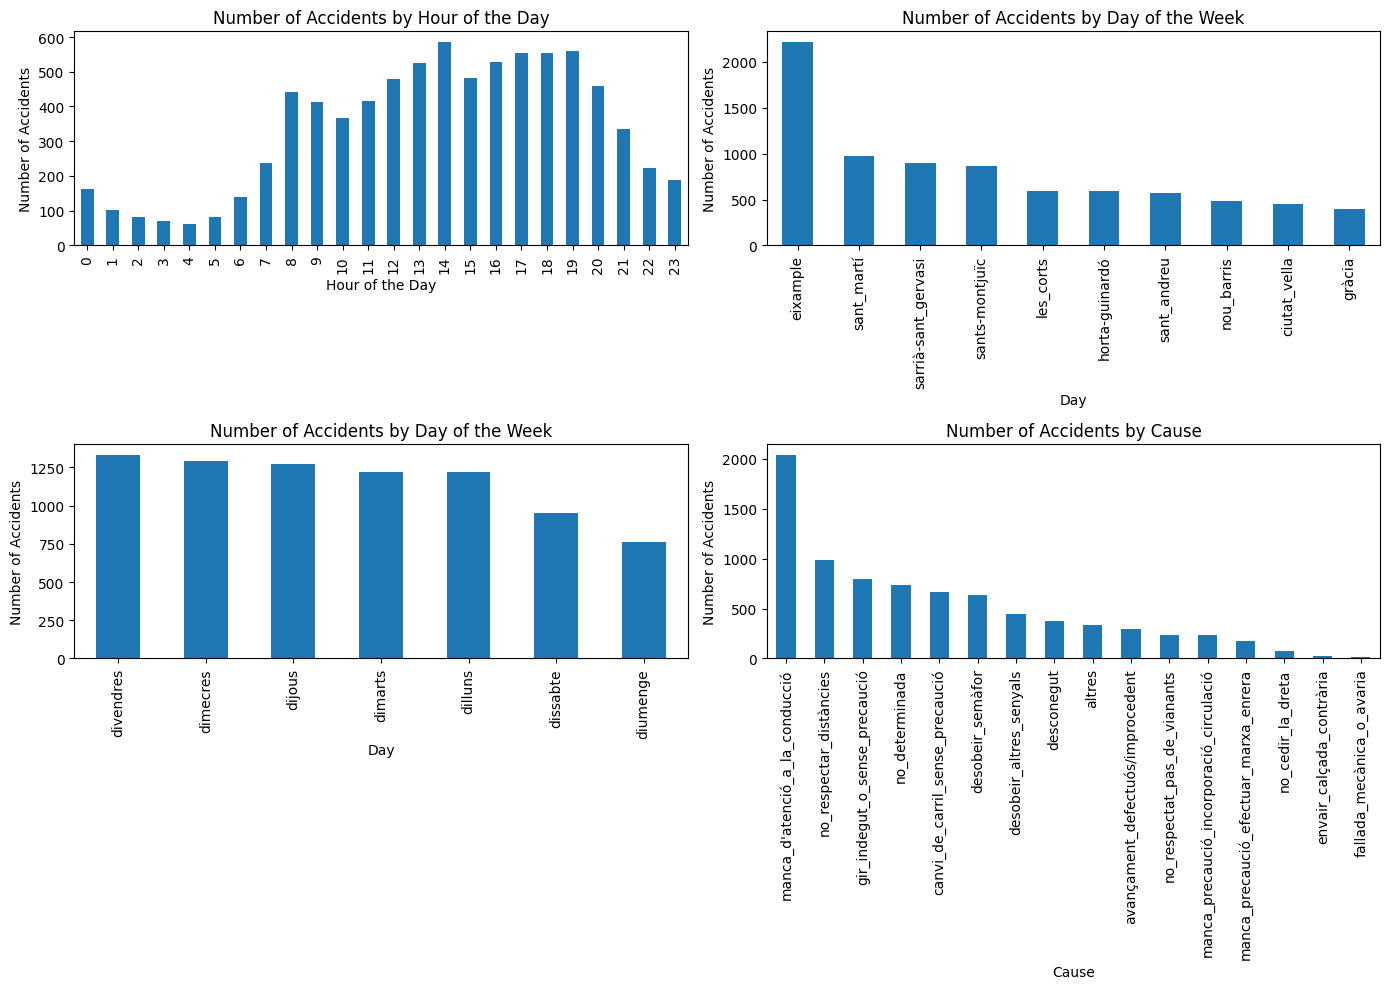

In [155]:
# Create a figure with four subplots (2 rows, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Plot 1: Histogram of accidents by hour of the day
data.groupby(["hora_dia"])['numero_expedient'].count().plot(kind="bar", ax=axes[0, 0])
axes[0, 0].set_title('Number of Accidents by Hour of the Day')
axes[0, 0].set_xlabel('Hour of the Day')
axes[0, 0].set_ylabel('Number of Accidents')

# Plot 2: Number of accidents by district
data.groupby(["nom_districte"])['numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[0, 1])
axes[0, 1].set_title('Number of Accidents by Day of the Week')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Number of Accidents')


# Plot 3: Number of accidents by day of the week
data.groupby(["descripcio_dia_setmana"])['numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[1, 0])
axes[1, 0].set_title('Number of Accidents by Day of the Week')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Number of Accidents')

# Plot 4: Number of accidents by cause
data.groupby(["descripcio_causa_mediata"])['numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[1, 1])
axes[1, 1].set_title('Number of Accidents by Cause')
axes[1, 1].set_xlabel('Cause')
axes[1, 1].set_ylabel('Number of Accidents')

# Adjust spacing between subplots
plt.tight_layout()

# Display all plots together
plt.show()


---
# Análisis de Insights

Podemos ver que **Eixample** es el distrito con más accidentes, y dentro del mismo, el barrio **La Dreta de Eixample** es el que lidera la tabla.

A su vez, se observa una tendencia en el aumento del número de accidentes en horarios determinados, principalmente desde las **14 a las 20 horas**.

En cuanto a la causa, la **carencia de atención a la conducción** es la principal causa de accidentes.

No parece haber diferencia en la cantidad de accidentes por día de semana, a excepción de una disminución en el número durante los **sábados y domingos**.

---

# Justificación de la selección de features

Basándome en este análisis , considero las **features** más importantes el **distrito** y la **hora del día**, y las selecciono para mi target inicial.

---


In [ ]:
df['num_accidents'] = df.groupby(['Codi_districte', 'Hora_dia'])['Hora_dia'].transform('count')


---

# Reducción de dimensionalidad

Procedo a eliminar las  **coordenadas** porque su información espacial relevante ya esta contenida en  **Codi_districte** y **Codi_barrio**. 
Esto puede ayudar a simplificar el modelo, y reducir el overfitting.



In [ ]:
lgb_model = lgb.LGBMRegressor(**lgb_params)

# Train the model with validation set for early stopping
lgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(10)])

# Predict on train set to assess model overfitting
y_train_pred = lgb_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Feature importance
importance = lgb_model.feature_importances_

def plot_feature_importance(importance, feature_cols):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values(by='importance', ascending=False).head(50)

    # Plot feature importance as a horizontal bar plot
    plt.figure(figsize=(5, 12))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance (Top50)')
    plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
    plt.show()
plot_feature_importance(importance, feature_cols)

# Predict on validation set and calculate MAE
y_valid_pred = lgb_model.predict(X_valid)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)
print(f"\nTrain MAE: {train_mae:.4f}")
print(f"\nValidation MAE: {valid_mae:.4f}")

# Predict on test set and calculate MAE on test set
y_test_pred = lgb_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"\nTest MAE: {test_mae:.4f}")

# ----------------- CV BENCHMARK -------------------
# Initial features: Validation MAE: 0.6600, Test MAE: 0.6119

---

# Elección de la variable objetivo

La elección de **Codi_districte** y **Hora_dia** como variables clave para el modelo se justifica por su notable influencia en la ocurrencia de accidentes. El **Codi_districte** proporciona información sobre las áreas geográficas donde se producen los accidentes, permitiendo identificar patrones específicos de cada distrito que pueden estar relacionados con la infraestructura, el tráfico o la densidad poblacional.

Por otro lado, **Hora_dia** permite captar la variación temporal en los accidentes, dado que ciertos períodos del día son más propensos a accidentes debido al aumento del tráfico. La combinación de estas dos variables ofrece una perspectiva comprensiva sobre **cuándo y dónde** es más probable que ocurran los accidentes, lo que las convierte en elementos fundamentales para mejorar la seguridad vial.

---

# Análisis de correlación

Realizo a continuación un análisis de correlación sobre las variables **Codi_districte** y **Hora_dia** para entender las relaciones entre los datos. Primero **factorizo** las variables categoricas, para darles un valor numérico y poder compararlas con las otras variables.

In [ ]:
df['Codi_districte'] = pd.factorize(df['Codi_districte'])[0]
df['Descripcio_dia_setmana'] = pd.factorize(df['Descripcio_dia_setmana'])[0]
df['Descripcio_torn'] = pd.factorize(df['Descripcio_torn'])[0]


In [ ]:
df = df.drop(['Numero_expedient', 'Nom_districte', 'Nom_barri', 'Nom_carrer', 'Num_postal ', 'Longitud_WGS84', 'Latitud_WGS84'], axis=1)


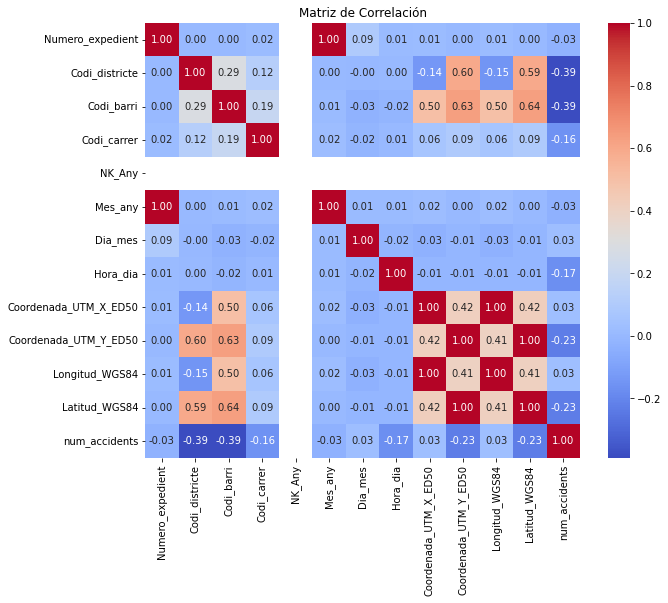

Correlación con num_accidents:
num_accidents            1.000000
Longitud_WGS84           0.033583
Coordenada_UTM_X_ED50    0.030756
Dia_mes                  0.027323
Numero_expedient        -0.030085
Mes_any                 -0.034285
Codi_carrer             -0.158840
Hora_dia                -0.170848
Latitud_WGS84           -0.230297
Coordenada_UTM_Y_ED50   -0.231340
Codi_barri              -0.387743
Codi_districte          -0.389830
NK_Any                        NaN
Name: num_accidents, dtype: float64


In [157]:
correlation_matrix = df.corr()

# Visualizar la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de Correlación")
plt.show()

print("Correlación con num_accidents:")
print(correlation_matrix['num_accidents'].sort_values(ascending=False))

<h1 style="font-size: 15px;">muestra una relación cuantificable entre estas características y el número de accidentes.
    Aunque la correlación con Hora_dia es mas baja, el Codi_districte muestra una correlación mayor</h1>

## Modelado y pipeline

In [ ]:
# division de datos
X = df.drop('num_accidents', axis=1)
y = df['num_accidents']

# columnas numericas y categoricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# definir modelos y pipelines
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# hiperparámetros Random Forest
rf_parametros = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__max_depth': randint(5, 30),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': uniform(0.1, 0.9),
    'regressor__bootstrap': [True, False],
    'regressor__oob_score': [True, False],
    'regressor__max_samples': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Hiperparámetros XGBoost
xgb_parametros = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__max_depth': randint(3, 12),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.6, 0.4),
    'regressor__min_child_weight': randint(1, 10),
    'regressor__gamma': uniform(0, 0.5),
    'regressor__alpha': uniform(0, 1),
    'regressor__lambda': uniform(0, 1),
    'regressor__scale_pos_weight': uniform(0.5, 1.5)
}

# Busquedade hiperparámetros y entrenamiento
rf = RandomizedSearchCV(rf_pipeline, rf_parametros, n_iter=10, cv=5, n_jobs=-1, random_state=42, error_score='raise')
xgb = RandomizedSearchCV(xgb_pipeline, xgb_parametros, n_iter=10, cv=5, n_jobs=-1, random_state=42, error_score='raise')

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Evaluación
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, mae, mse, rmse

metricas_rf = evaluate_model(rf.best_estimator_, X_test, y_test)
metricas_xgb = evaluate_model(xgb.best_estimator_, X_test, y_test)

print("Metricas Random Forest:", metricas_rf)
print("Metricas XGBoost :", metricas_xgb)

# elegir el mejor modelo
best_model = rf if metricas_rf[0] > metricas_xgb[0] else xgb
print("Mejor modelo:", "RandomForest" if best_model == rf else "XGBoost")

#importancia de características 
importances = best_model.best_estimator_.named_steps['regressor'].feature_importances_

# nombres de características numéricas
numeric_feature_names = numeric_features.tolist()

# Obtener nombres de características de OneHotEncoder
ohe = best_model.best_estimator_.named_steps['preprocessor'].transformers[1][1]
ohe_feature_names = []
for i, cat in enumerate(ohe.categories_):
    for c in cat:
        ohe_feature_names.append(f"{categorical_features[i]}_{c}")

# Combinar nombres de características
feature_names = np.concatenate([numeric_feature_names, ohe_feature_names])

# Crear DataFrame para la importancia de características
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print(feature_importance.head(10))


Lo transformo en una funcion para poder realizar cambios en la variable objetivo con facilidad

In [ ]:
def entrenar_evaluar_modelos(df, target, n_iter=10, test_size=0.2, random_state=42):
 
"""
    Esta función entrena y evalúa con Random Forest y XGBoost

    Args:
    - df: DataFrame 
    - target: columna objetivo a predecir
    - n_iter: numero de iteraciones para buscar hiperparámetros (default 10).
    - test_size: proporcion de datos utilizada para test (default 0.2).
    - random_state: Semilla de números aleatorios (default 42).

    Returns:
    - rf: modelo Random Forest entrenado.
    - xgb: modelo XGBoost entrenado.
    - feature_importance: DataFrame con un ranking de laimportancia de las características de los modelos.
    
    La función hace lo siguiente:
     - Separa los datos en  train y test.
     - Diferencia los tipos de datos segun si son numéricas o categoricas.
     - Construye pipelines para Random Forest y XGBoost.
     - Realiza una RandomizedSearchCV de hiperparámetros para los modelos.
     - Entrena los modelos y calcula el rendimiento utilizando métricas como R^2, MAE y RMSE.
     - Compara los modelos y selecciona el mejor.
     - Calcula las feature importance.
    """
    # División de datos
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Columnas numéricas y categóricas
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
    
    # Definir modelos y pipelines
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=random_state))])
    
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=random_state))])
    
    # Hiperparámetros Random Forest
    rf_parametros = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__max_depth': randint(5, 30),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 10),
        'regressor__max_features': uniform(0.1, 0.9),
        'regressor__bootstrap': [True, False],
        'regressor__oob_score': [True, False],
        'regressor__max_samples': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    
    # Hiperparámetros XGBoost
    xgb_parametros = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__max_depth': randint(3, 12),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__subsample': uniform(0.7, 0.3),  
        'regressor__colsample_bytree': uniform(0.6, 0.4), 
        'regressor__min_child_weight': randint(1, 10),
        'regressor__gamma': uniform(0, 0.5),
        'regressor__alpha': uniform(0, 1),
        'regressor__lambda': uniform(0, 1),
        'regressor__scale_pos_weight': uniform(0.5, 1.5)
    }
    
    # Búsqueda de hiperparámetros y entrenamiento
    rf = RandomizedSearchCV(rf_pipeline, rf_parametros, n_iter=n_iter, cv=5, n_jobs=-1, random_state=random_state, error_score='raise')
    xgb = RandomizedSearchCV(xgb_pipeline, xgb_parametros, n_iter=n_iter, cv=5, n_jobs=-1, random_state=random_state, error_score='raise')
    
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Evaluación
    def evaluate_model(model, X_test, y_test):
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        return r2, mae, mse, rmse
    
    metricas_rf = evaluate_model(rf.best_estimator_, X_test, y_test)
    metricas_xgb = evaluate_model(xgb.best_estimator_, X_test, y_test)
    
    print("Métricas Random Forest:", metricas_rf)
    print("Métricas XGBoost:", metricas_xgb)
    
    # Elegir el mejor modelo
    best_model = rf if metricas_rf[0] > metricas_xgb[0] else xgb
    print("Mejor modelo:", "RandomForest" if best_model == rf else "XGBoost")
    
    # Importancia de características
    importances = best_model.best_estimator_.named_steps['regressor'].feature_importances_
    
    # Nombres de características numéricas
    numeric_feature_names = numeric_features.tolist()
    
    # Obtener nombres de características de OneHotEncoder
    ohe = best_model.best_estimator_.named_steps['preprocessor'].transformers_[1][1]
    ohe_feature_names = []
    for i, cat in enumerate(ohe.categories_):
        for c in cat:
            ohe_feature_names.append(f"{categorical_features[i]}_{c}")
    
    # Combinar nombres de características
    feature_names = np.concatenate([numeric_feature_names, ohe_feature_names])
    
    # Crear DataFrame para la importancia de características
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print(feature_importance.head(10))
    
    return rf, xgb, feature_importance



Pruebo con diferentes targets.

In [ ]:
# Target original
df['num_accidents'] = df.groupby(['Codi_districte', 'Hora_dia'])['Hora_dia'].transform('count')
resultados_originales = entrenar_evaluar_modelos(df, 'num_accidents')

# Nuevo target (accidentes por día en cada distrito)
df['num_accidents_diarios'] = df.groupby(['Codi_districte', 'Data'])['Data'].transform('count')
resultados_diarios = entrenar_evaluar_modelos(df, 'num_accidents_diarios')

# Compara los resultados

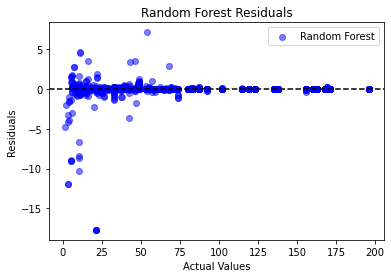

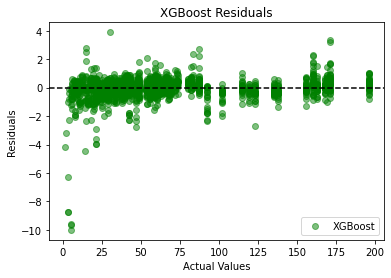

In [173]:
# Calculate residuals
rf_residuals = y_test - rf_test_preds
xgb_residuals = y_test - xgb_test_preds

# Plot Random Forest residuals
plt.scatter(y_test, rf_residuals, color='blue', label='Random Forest', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Random Forest Residuals")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Plot XGBoost residuals
plt.scatter(y_test, xgb_residuals, color='green', label='XGBoost', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("XGBoost Residuals")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.legend()
plt.show()